# <center>  LSTM Model on Amazon Fine Food Reviews Dataset </center>
___

###  <b>Exercise</b> :
1.	Download Amazon Fine Food Reviews dataset from Kaggle. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Get vocabulary for each word in corpus.
3.	Also get the frequencies for each word and index them from most frequent to less frequent.
4.	Now run LSTM Models on the dataset.
5.	Also try 2-layers of LSTM.
6.	Also use dropout and batch normalization and plot train-test error vs epochs for each model.
7.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.


### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform and perform LSTM to find the polarity of the dataset.<span>

---

In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import islice

from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.preprocessing import sequence
from keras.initializers import he_normal
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import L1L2
from prettytable import PrettyTable

Using TensorFlow backend.


<br/>
<br/>

#### Load Dataset

In [2]:
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# For Data Cleaning Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=1JXCva5vXdIPgHbfNdD9sgnySqELoVtpy
# dataset - https://drive.google.com/open?id=1IoDoTT8TfDu53N6cyKg6xVCU-FDPHyIF

# For Text Preporcessing Steps follow this link -
# ipython notebook - https://drive.google.com/open?id=18-AkTzzEhCwM_hflIbDNBMAP-imX4k4i
# dataset - https://drive.google.com/open?id=1SfDwwXFhDpjgtfIE5O_E80SO89xRc8Sa

# Load dataset
def load_review_dataset(do_not_sample=True, sample_count=1):
    # Create connection object to load sqlite dataset
    connection = sqlite3.connect('finalDataSet.sqlite')

    # Load data into pandas dataframe.
    reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
    reviews_df = reviews_df.drop(columns=['index'])   
       
    # Sample dataset
    if do_not_sample == False:
        reviews_df = reviews_df.sample(sample_count)
        
    # Convert timestamp to datetime.
    reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

    # Sort the data on the basis of time.
    reviews_df = reviews_df.sort_values(by=['Time'])    
    
    return reviews_df


# Load 'finalDataSet.sqlite' in panda's daraframe.
reviews_df = load_review_dataset(do_not_sample = True,sample_count = 1)


# Make CleanedText as a dataset for clustering
cleaned_text = reviews_df['CleanedText'].values

print("Dataset Shape : \n",cleaned_text.shape)

reviews_df['Score'] = reviews_df['Score'].map(lambda x : 1 if x == 'positive' else 0)
reviews_df.head(5)

Dataset Shape : 
 (351237,)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
382,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
250,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
383,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
269,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09 05:30:00,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
369,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19 05:30:00,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


<br/>
<br/>

#### Lets calculate frequencies for each word and index them from most frequent to less frequent.

In [3]:
all_words=[]
for sentence in cleaned_text:
    words = sentence.split()
    all_words += words
    
print("Shape of the data : ",cleaned_text.shape)
print("Number of sentences present in complete dataset : ",len(all_words))

counts = Counter(all_words)
print("Number of unique words present in whole corpus: ",len(counts.most_common()))
vocab_size = len(counts.most_common()) + 1
top_words_count = 5000
sorted_words = counts.most_common(top_words_count)

word_index_lookup = dict()
i = 1
for word,frequency in sorted_words:
    word_index_lookup[word] = i
    i += 1

print()
print("Top 25 words with their frequencies:")
print(counts.most_common(25))
print()
print("Top 25 words with their index:")
print(list(islice(word_index_lookup.items(), 25)))

Shape of the data :  (351237,)
Number of sentences present in complete dataset :  12901678
Number of unique words present in whole corpus:  93072

Top 25 words with their frequencies:
[('like', 160957), ('tast', 153682), ('flavor', 122605), ('good', 120139), ('love', 111232), ('use', 110705), ('product', 110217), ('one', 108864), ('great', 104928), ('tri', 96815), ('tea', 89507), ('coffe', 88109), ('get', 80051), ('make', 79567), ('food', 69353), ('would', 67655), ('buy', 63884), ('time', 60622), ('realli', 57989), ('eat', 57247), ('amazon', 55670), ('order', 55535), ('dont', 53855), ('much', 53351), ('price', 53027)]

Top 25 words with their index:
[('like', 1), ('tast', 2), ('flavor', 3), ('good', 4), ('love', 5), ('use', 6), ('product', 7), ('one', 8), ('great', 9), ('tri', 10), ('tea', 11), ('coffe', 12), ('get', 13), ('make', 14), ('food', 15), ('would', 16), ('buy', 17), ('time', 18), ('realli', 19), ('eat', 20), ('amazon', 21), ('order', 22), ('dont', 23), ('much', 24), ('price'

<br/>
<br/>

#### Lets add new column to our existing review dataframe with the index value of the words, which are present in 'CleanedText' columns.

In [4]:
def apply_text_index(row):  
    holder = []
    for word in row['CleanedText'].split():
        if word in word_index_lookup:
            holder.append(word_index_lookup[word]) 
        else:
            holder.append(0)            
    return holder


reviews_df['CleanedText_Index'] = reviews_df.apply(lambda row: apply_text_index(row),axis=1)
reviews_df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_Index
382,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,"[4375, 34, 2156, 1220, 343, 159, 1803, 447, 50..."
250,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,"[1555, 0, 3692, 2656, 212, 2557, 0, 0, 0, 933,..."
383,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,"[4375, 159, 1429, 1220, 0, 0, 0, 4375, 9, 447,..."
269,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09 05:30:00,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...,"[8, 1220, 1220, 1661, 267, 0, 3098, 756, 350, ..."
369,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,2000-01-19 05:30:00,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...,"[100, 63, 1220, 1429, 2164, 122, 1098, 454, 0,..."


<br/>
<br/>

#### Split dataset into 70 : 30 split.

In [5]:
# Split data into train and test
x_train, x_test, y_train, y_test = train_test_split(reviews_df['CleanedText_Index'].values,
                                                            reviews_df['Score'],
                                                            test_size=0.3,
                                                            shuffle=False,
                                                            random_state=0)

In [6]:
print("Total number words present in first review:\n",len(x_train[1]))
print()
print("List of word indexes present in first review:\n", x_train[1])
print()

Total number words present in first review:
 20

List of word indexes present in first review:
 [1555, 0, 3692, 2656, 212, 2557, 0, 0, 0, 933, 3049, 0, 0, 0, 4623, 111, 2385, 542, 2843, 1495]



<br/>

#### Lets apply padding to force every review to have equal length.

In [7]:
max_review_length = 500
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Total number words present in first review after padding:\n",len(x_train[1]))
print()
print("List of word indexes present in first review padding:\n", x_train[1])
print()

Total number words present in first review after padding:
 500

List of word indexes present in first review padding:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

<br/>
<br/>

#### Model 1 - with 1 - LSTM Layer

In [8]:
# Batch size 
batch_size = 192 

# Number of time whole data is trained
epochs = 10

# Embedding vector size
embedding_vecor_length = 32

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

# Plot train and cross validation loss
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()   

In [9]:
# Instantiate sequntial model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer
model.add(LSTM(100))

# Add dropout
model.add(Dropout(0.20))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           2978336   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,031,765
Trainable params: 3,031,701
Non-trainable params: 64
________________________________________________

In [10]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 92.77%


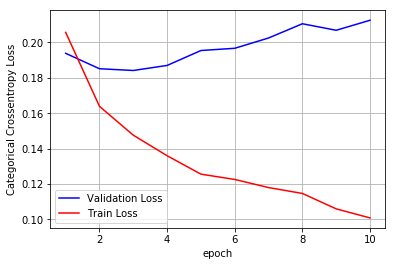

In [11]:
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

##### After 1st epoch we got 92.51% accuracy, and if we train further we starts to overfit, as validation error does not decreses.

<br/>
<br/>

#### Model 2 - With 2 - LSTM Layers

In [12]:
%%time
# Instantiate sequntial model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 1
model.add(LSTM(100,return_sequences=True))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 2
model.add(LSTM(100))

# Add dropout
model.add(Dropout(0.20))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           2978336   
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

In [13]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 92.67%


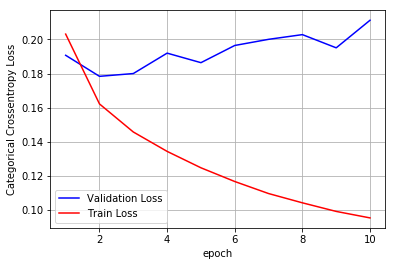

In [14]:
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

##### After 1st epoch we got 92.30% accuracy, and if we train further we starts to overfit, as validation error does not decreses.

<br/>
<br/>

#### Model 3 - With 5 - LSTM Layers

In [9]:
# Instantiate sequntial model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 1
model.add(LSTM(100,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 2
model.add(LSTM(80,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 3
model.add(LSTM(60,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.30))

# Add LSTM Layer 4
model.add(LSTM(40,return_sequences=True,bias_regularizer=reg))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.40))

# Add LSTM Layer 5
model.add(LSTM(20))

# Add dropout
model.add(Dropout(0.50))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           2978336   
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 80)           57920     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 80)           0   

In [10]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 92.52%


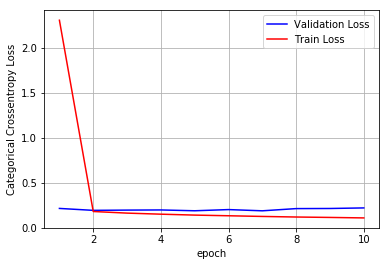

In [11]:
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

##### After 7th epoch, gap between train error and test error increases drastically, so to avoid overfitting we should train our model upto 7th epoch.

##### We can see that, as we increase number of LSTM layers chance of overfitting the model reduces.

<br/>
<br/>

In [2]:
# Pretty table instance
ptable = PrettyTable()
ptable.title = "Comparison between different LSTM Models"
ptable.field_names = ['Number of LSTM Layers','Epoch','Testing Accuracy','Does Overfit']
ptable.add_row(["1","10","90.77","Yes"])
ptable.add_row(["2","10","92.67","Yes"])
ptable.add_row(["5","10","92.52","No - Optimal Epoch value is 7"])

# Print pretty table values
print(ptable)

+----------------------------------------------------------------------------------+
|                     Comparison between different LSTM Models                     |
+-----------------------+-------+------------------+-------------------------------+
| Number of LSTM Layers | Epoch | Testing Accuracy |          Does Overfit         |
+-----------------------+-------+------------------+-------------------------------+
|           1           |   10  |      90.77       |              Yes              |
|           2           |   10  |      92.67       |              Yes              |
|           5           |   10  |      92.52       | No - Optimal Epoch value is 7 |
+-----------------------+-------+------------------+-------------------------------+


---
### Observations :
---

> 1. Tried different LSTM architectures on Amazon Fine Food Review Dataset.
> 2. 'sigmoid' is used as an activation function to develop LSTM network. 
> 3. 'Adam' is used as an optimizer to develop LSTM network. 
> 4. Introduced batch normalization and dropout in between hidden layers.

### Note:
#### To avoid overfitting we can try below following measures:
#### We can increase the number of epochs to some reasonable number like 100 - 300 ,
#### We can introduce 'recurrent_regularizer' on LSTM layer, for different values of L1 or L2 or elasticnet ,
#### We can also try 'kernel_regularizer' on LSTM layer, for different values of L1 or L2 or elasticnet , 
#### We can combine CNN + MaxPooling + LSTM and observe the any decrease in validation error.


<br/>
<br/>
